# Setting up

In [1]:
from distribution_classes import Simple_Gaussian, Gaussian_Grid
from generate_means import regular_expectancy, new_expectancy, box_comp
from model_building import build_model
from optimisation import estimate_params

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")


In [5]:
dev

device(type='cpu')

In [6]:
data_dimensions = 2 # how many dimensions are there in our variable

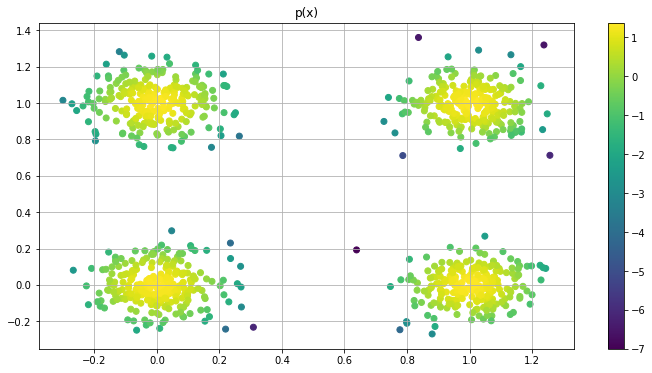

In [7]:
p_dist = Gaussian_Grid(data_dimensions, 2, 0.1)
samps = p_dist.sampler(1000)
log_p = p_dist.log_pdf(samps).cpu()
samps = samps.cpu()
plt.figure(figsize=(12, 6))
plt.scatter(samps[:, 0], samps[:, 1], c = log_p)
cbar= plt.colorbar()
plt.title('p(x)')
plt.grid()
plt.show()

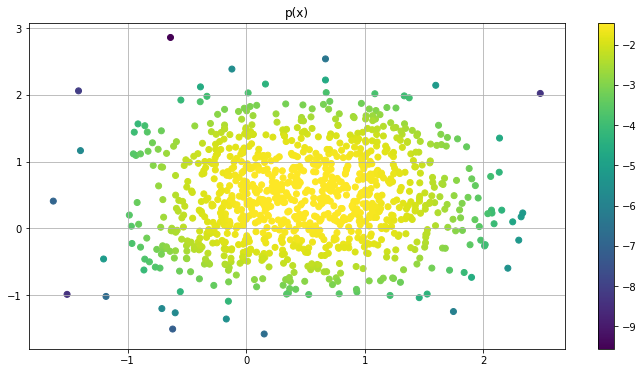

In [8]:
p_dist = Gaussian_Grid(data_dimensions, 2, 0.5)
samps = p_dist.sampler(1000)
log_p = p_dist.log_pdf(samps).cpu()
samps = samps.cpu()
plt.figure(figsize=(12, 6))
plt.scatter(samps[:, 0], samps[:, 1], c = log_p)
cbar= plt.colorbar()
plt.title('p(x)')
plt.grid()
plt.show()

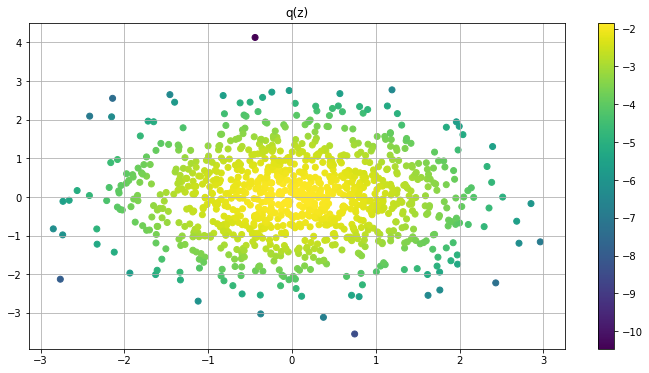

In [9]:
q_dist = Simple_Gaussian(dimensions = data_dimensions)
samps = q_dist.sampler(1000)
log_p = q_dist.log_pdf(samps).cpu()
samps = samps.cpu()
plt.figure(figsize=(12, 6))
plt.scatter(samps[:, 0], samps[:, 1], c = log_p)
cbar= plt.colorbar()
plt.title('q(z)')
plt.grid()
plt.show()

# Run test

In [10]:
def func(x):
    #specify h(x)
    return (x*x*x).sum(dim=1)

In [11]:
model = build_model(data_dimensions, 3, 3, 'maf')

In [12]:
model = model.to(dev)
p_dist = p_dist.to(dev)
q_dist = q_dist.to(dev)

Cur iter: 0
Curr_loss: tensor(3.3920, grad_fn=<AddBackward0>)
Min_loss: 3.3919665813446045
Current epochs: 8000
Current tolerance: tensor(3.8862e-05, grad_fn=<AbsBackward>)


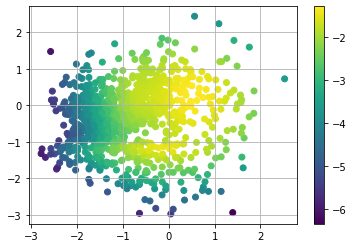

In [13]:
estimate_params(p_dist, q_dist, func, model, sample_size = 10**3, lear_rt = 1e-3, epoch_amnt = 20*10**3, lr_downing_num =5)

In [14]:
model.eval();

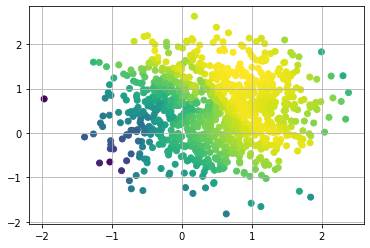

In [15]:
#f(X)
#if done well, should look like q(z)

testin = p_dist.sampler(10**3)
trans, log_det = model.forward(testin)
testin = testin.cpu()
color = (q_dist.log_pdf(trans) + log_det.squeeze()).detach().cpu()
plt.scatter(testin[:, 0], testin[:, 1],  c = color)
plt.grid()

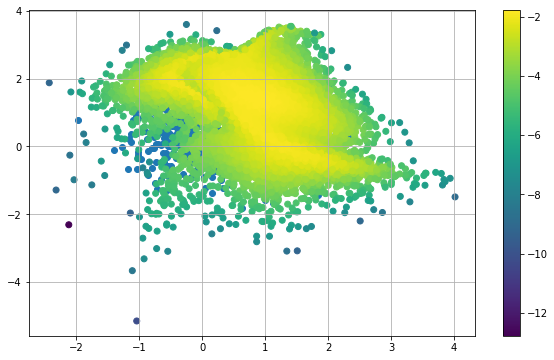

In [16]:
# g(Z), Z~q(z) compared to X~p(x)

new_data = q_dist.sampler(10**4)
trans, log_det = model.forward(new_data, mode='inverse')
plotting = trans.detach().cpu()
color = (q_dist.log_pdf(new_data) - log_det.reshape(1, -1)).detach().cpu()
plt.figure(figsize=(10, 6))
plt.scatter(testin[:, 0], testin[:, 1])
plt.scatter(plotting[:, 0], plotting[:, 1], c = color )

cbar= plt.colorbar()
plt.grid()

In [17]:
reg = regular_expectancy(func, p_dist, 100, 10**3)

  0%|          | 0/100 [00:00<?, ?it/s]

In [18]:
newe = new_expectancy(func, p_dist, q_dist, 100, 10**3, model)

  0%|          | 0/100 [00:00<?, ?it/s]

0
10
20
30
40
50
60
70
80
90


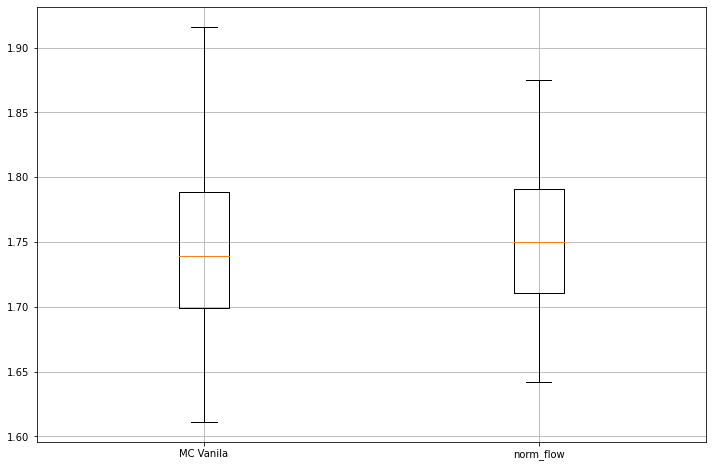

In [19]:
box_comp(reg, newe) 

In [20]:
van_var = np.var(reg)
flow_var = np.var(newe)
print("Baseline variance:", van_var)
print("Variance of our approach:", flow_var)
print("Reduction rate:", van_var/flow_var)

Baseline variance: 0.00546387575417869
Variance of our approach: 0.002888068797865428
Reduction rate: 1.8918786693090694
